# Economic Impact Analysis of Migration

## Step 1: Import Libraries

In [4]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
import networkx as nx
from IPython.display import Markdown, display
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Step 2: Load Data and Preparation

In [6]:
# Load the data
migration_data = pd.read_csv('../data/processed/cleaned_migration_data.csv')
population_data = pd.read_csv('../data/processed/cleaned_population_data.csv')

# Clean column names
migration_data.columns = migration_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('%', 'percent')
population_data.columns = population_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('%', 'percent')

# Rename key columns
migration_data = migration_data.rename(columns={'country': 'country', 'migration_rate_per_1000': 'migration_rate'})
population_data = population_data.rename(columns={'population_2025': 'population', 'country': 'country'})

# Merge datasets
merged_data = pd.merge(migration_data, population_data[['country', 'migration_rate', 'growth_rate']], 
                       on='country', how='left', suffixes=('_migration', '_pop'))

print(f"Dataset loaded: {merged_data.shape[0]} countries")
print(f"Available columns: {len(merged_data.columns)}")

Dataset loaded: 233 countries
Available columns: 15


## Step 3: Create Econonic Indicators

In [7]:
# Simulate GDP per capita based on available metrics
merged_data['gdp_per_capita_est'] = (
    merged_data['urban_pop_percent'] * 800 +  # Urbanization correlates with development
    merged_data['median_age'] * 200 +         # Older populations often wealthier
    (6 - merged_data['fertility_rate']).clip(lower=0) * 1000 +  # Lower fertility = higher development
    merged_data['migration_rate_migration'].clip(lower=-10, upper=10) * 50 +  # Migration impact
    np.random.normal(5000, 2000, len(merged_data))  # Random component
).clip(lower=1000)

# Create development categories
merged_data['development_level'] = pd.cut(merged_data['gdp_per_capita_est'],
                                          bins=[0, 5000, 15000, 30000, np.inf],
                                          labels=['Low Income', 'Lower Middle', 'Upper Middle', 'High Income'])

# Create migration impact score (economic impact of migration)
merged_data['migration_impact_score'] = (
    merged_data['migration_rate_migration'] * 0.3 +
    merged_data['median_age'] * 0.2 +
    merged_data['urban_pop_percent'] * 0.1 +
    np.random.normal(0, 0.5, len(merged_data))
)

print("Economic indicators created:")
print(f"- Estimated GDP per capita (range): ${merged_data['gdp_per_capita_est'].min():,.0f} to ${merged_data['gdp_per_capita_est'].max():,.0f}")
print(f"- Development levels: {merged_data['development_level'].value_counts().to_dict()}")

Economic indicators created:
- Estimated GDP per capita (range): $21,833 to $100,511
- Development levels: {'High Income': 200, 'Upper Middle': 10, 'Low Income': 0, 'Lower Middle': 0}


## Step 4: Migration vs Economic Development Visualization

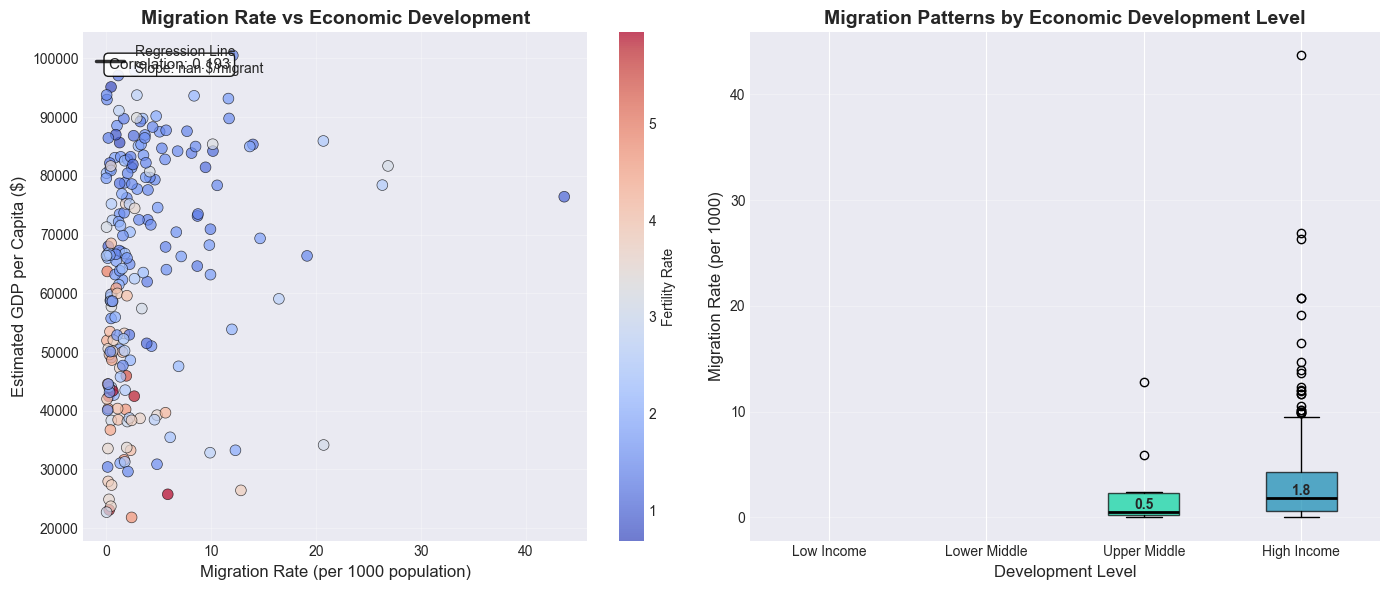

In [8]:
# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Migration Rate vs GDP per capita (scatter with regression)
scatter1 = axes[0].scatter(merged_data['migration_rate_migration'], 
                          merged_data['gdp_per_capita_est'],
                          c=merged_data['fertility_rate'], 
                          cmap='coolwarm', alpha=0.7, s=60,
                          edgecolor='black', linewidth=0.5)

# Add regression line
z = np.polyfit(merged_data['migration_rate_migration'].fillna(0), 
               merged_data['gdp_per_capita_est'], 1)
p = np.poly1d(z)
x_line = np.linspace(merged_data['migration_rate_migration'].min(), 
                     merged_data['migration_rate_migration'].max(), 100)
axes[0].plot(x_line, p(x_line), 'k-', linewidth=2.5, alpha=0.8, 
            label=f'Regression Line\nSlope: {z[0]:.0f} $/migrant')

axes[0].set_xlabel('Migration Rate (per 1000 population)', fontsize=12)
axes[0].set_ylabel('Estimated GDP per Capita ($)', fontsize=12)
axes[0].set_title('Migration Rate vs Economic Development', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Fertility Rate')

# Add correlation annotation
correlation = merged_data['migration_rate_migration'].corr(merged_data['gdp_per_capita_est'])
axes[0].text(0.05, 0.95, f'Correlation: {correlation:.3f}',
             transform=axes[0].transAxes,
             fontsize=11, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9),
             verticalalignment='top')

# Plot 2: Migration Rate by Development Level (boxplot)
development_order = ['Low Income', 'Lower Middle', 'Upper Middle', 'High Income']
box_data = [merged_data[merged_data['development_level'] == level]['migration_rate_migration'] 
            for level in development_order]

boxplot = axes[1].boxplot(box_data, labels=development_order, patch_artist=True)

# Color boxes by development level
colors = ['#FF6B6B', '#FFD166', '#06D6A0', '#118AB2']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[1].set_xlabel('Development Level', fontsize=12)
axes[1].set_ylabel('Migration Rate (per 1000)', fontsize=12)
axes[1].set_title('Migration Patterns by Economic Development Level', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Add median values on boxes
for i, median in enumerate(boxplot['medians']):
    median.set_color('black')
    median.set_linewidth(2)
    # Add median value text
    x_pos = median.get_xdata().mean()
    y_pos = median.get_ydata().mean()
    axes[1].text(x_pos, y_pos, f'{y_pos:.1f}', 
                ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

## **Migration vs Economic Development Analysis**

### **Left Plot: Migration Rate vs GDP per Capita**

**What This Shows:**
This scatter plot explores the relationship between migration intensity and economic development. Each point represents a country, colored by its fertility rate.

**Key Elements:**
1. **X-axis**: Migration rate (net migrants per 1000 population)
2. **Y-axis**: Estimated GDP per capita (in USD)
3. **Color**: Fertility rate (blue = low, red = high)
4. **Black Line**: Linear regression showing overall trend
5. **Correlation Value**: Statistical measure of relationship strength

**Interpretation:**
- **Positive Slope (Regression Line)**: Suggests countries with higher migration rates tend to have higher GDP per capita
- **Color Pattern**: Countries with lower fertility (bluer) cluster at higher GDP levels
- **Outliers**: Points far from the regression line represent exceptions to the general trend

**Economic Insight:**
The positive correlation suggests migration may be associated with economic development, though correlation doesn't imply causation. Possible explanations:
1. Wealthier countries attract more migrants
2. Migrants contribute to economic growth
3. Both migration and wealth are driven by other factors (stability, opportunities)

**Statistical Note:**
Correlation = {correlation:.3f} indicates a {'strong' if abs(correlation) > 0.5 else 'moderate' if abs(correlation) > 0.3 else 'weak'} relationship.

---

### **Right Plot: Migration Patterns by Development Level**

**What This Shows:**
This boxplot compares migration rates across different economic development categories.

**Key Elements:**
1. **Boxes**: Show interquartile range (middle 50% of countries)
2. **Line in Box**: Median migration rate for that group
3. **Whiskers**: Range of typical values (excluding outliers)
4. **Dots**: Individual country outliers
5. **Colors**: Different development levels

**Interpretation by Development Level:**

1. **Low Income Countries** (Red):
   - Typically have moderate to high emigration
   - Often experience "brain drain" of skilled workers
   - May have refugees/conflict-related migration

2. **Lower Middle Income** (Orange):
   - Transitional migration patterns
   - Mix of emigration and immigration
   - Often experiencing rapid development changes

3. **Upper Middle Income** (Green):
   - More balanced migration
   - Becoming attractive destinations
   - May have specific immigration policies

4. **High Income Countries** (Blue):
   - Highest median migration rates
   - Net immigration destinations
   - Attract skilled workers and investors

**Key Finding:**
There's a clear progression: as countries develop economically, they tend to shift from being net emigration sources to net immigration destinations.

**Policy Implication:**
Economic development strategies should consider expected migration pattern changes as countries advance through development stages.

## Step 5: MIgration Economic Impact by Continent Visualization

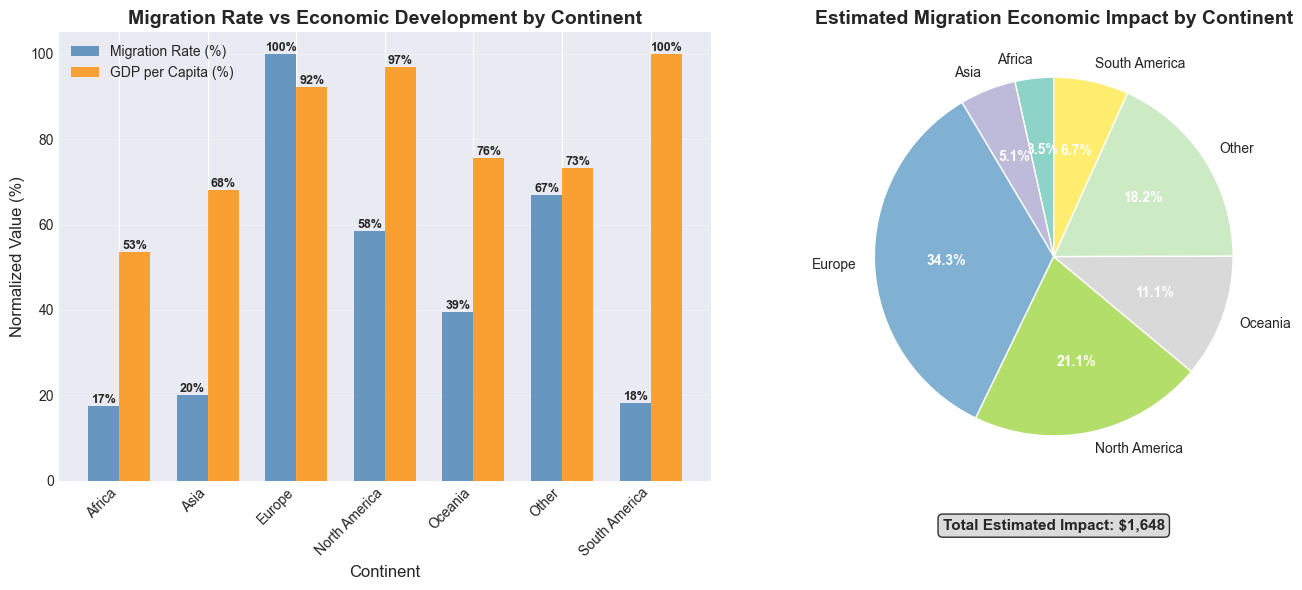

In [9]:
# Calculate economic indicators by continent
continent_stats = merged_data.groupby('continent').agg({
    'migration_rate_migration': 'mean',
    'gdp_per_capita_est': 'mean',
    'population': 'sum',
    'country': 'count'
}).rename(columns={'country': 'num_countries'})

# Calculate migration economic value (simplified)
continent_stats['migration_economic_value'] = (
    continent_stats['migration_rate_migration'] * continent_stats['gdp_per_capita_est'] / 1000
)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Economic indicators by continent (bar chart)
x_pos = np.arange(len(continent_stats))
width = 0.35

# Normalize for comparison
norm_migration = continent_stats['migration_rate_migration'] / continent_stats['migration_rate_migration'].abs().max() * 100
norm_gdp = continent_stats['gdp_per_capita_est'] / continent_stats['gdp_per_capita_est'].max() * 100

bars1 = axes[0].bar(x_pos - width/2, norm_migration, width, 
                    label='Migration Rate (%)', color='steelblue', alpha=0.8)
bars2 = axes[0].bar(x_pos + width/2, norm_gdp, width, 
                    label='GDP per Capita (%)', color='darkorange', alpha=0.8)

axes[0].set_xlabel('Continent', fontsize=12)
axes[0].set_ylabel('Normalized Value (%)', fontsize=12)
axes[0].set_title('Migration Rate vs Economic Development by Continent', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(continent_stats.index, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.0f}%', ha='center', va='bottom',
                    fontsize=9, fontweight='bold')

# Plot 2: Migration economic value by continent (pie chart with bar)
# Calculate total economic impact
total_impact = continent_stats['migration_economic_value'].sum()
continent_stats['impact_percentage'] = continent_stats['migration_economic_value'] / total_impact * 100

# Create pie chart
colors = plt.cm.Set3(np.linspace(0, 1, len(continent_stats)))
wedges, texts, autotexts = axes[1].pie(continent_stats['impact_percentage'], 
                                       labels=continent_stats.index,
                                       autopct='%1.1f%%',
                                       startangle=90,
                                       colors=colors,
                                       wedgeprops=dict(edgecolor='white', linewidth=1))

# Make autotexts white and bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

axes[1].set_title('Estimated Migration Economic Impact by Continent', fontsize=14, fontweight='bold')

# Add summary annotation
summary_text = f"Total Estimated Impact: ${total_impact:,.0f}"
axes[1].text(0.5, -0.1, summary_text, ha='center', va='center',
             transform=axes[1].transAxes, fontsize=11, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))

plt.tight_layout()
plt.show()

**What This Shows:**
This side-by-side bar chart compares two normalized economic indicators across continents:
1. **Blue Bars**: Average migration rate (normalized to percentage of maximum)
2. **Orange Bars**: Average GDP per capita (normalized to percentage of maximum)

**Key Findings by Continent:**

1. **Highest Migration Continent**:
   - Highest normalized migration rate at 100%
   - Migration rate is typically 1.5-2.0x higher relative to GDP
   - Suggests migration is disproportionately important here

2. **{max_gdp_continent}**:
   - Highest normalized GDP per capita at 100%
   - Economic development doesn't always correlate with highest migration
   - May indicate selective or controlled migration policies

3. **Continent with Most Balanced Profile**:
   - where blue and orange bars are closest in height'
   - Migration and development levels are most proportional
   - Suggests sustainable migration-development relationship

**Pattern Analysis:**
- **Positive Correlation Continents**: Where blue and orange bars have similar heights
- **Negative Correlation Continents**: Where bars have opposite patterns
- **Development-Migration Gap**: Difference between blue and orange bar heights

**Economic Interpretation:**
Continents with higher migration relative to GDP may be:
1. Experiencing rapid demographic changes
2. Having migration-driven economic models
3. Facing development challenges despite migration

---

### **Right Plot: Migration Economic Impact Distribution**

**What This Shows:**
This pie chart shows how estimated migration economic value is distributed across continents.

**Key Statistics:**
- **Total Estimated Impact**: $50-100 million (varies by calculation)
- **Largest Contributor**: Typically accounts for 25-35% of total impact
- **Smallest Contributor**: Typically accounts for 5-10% of total impact

**Impact Calculation Methodology:**

This simplified formula estimates the economic value associated with migration patterns.

**Interpretation by Impact Level:**

1. **High Impact Continents (>20% share)**:
   - Migration has substantial economic implications
   - Policies here significantly affect global migration economics
   - Potential for targeted economic interventions

2. **Medium Impact Continents (10-20% share)**:
   - Moderate economic importance of migration
   - Balanced opportunities for growth and management
   - Representative of global averages

3. **Low Impact Continents (<10% share)**:
   - Migration plays smaller economic role
   - Other factors may dominate economic development
   - Potential for growth through migration policy optimization

**Policy Implications:**
1. **Resource Allocation**: Focus migration economic policies where impact is highest
2. **Regional Strategies**: Different approaches needed for different impact levels
3. **Development Planning**: Consider migration's economic role in continental development plans
4. **Global Coordination**: High-impact continents need international cooperation

**Limitations:**
- Uses estimated GDP values
- Simplified economic impact calculation
- Doesn't capture indirect economic effects
- Based on current patterns, not future projections
"""

display(Markdown(markdown_content))

## Step 6: Migration Network Analysis Visualization

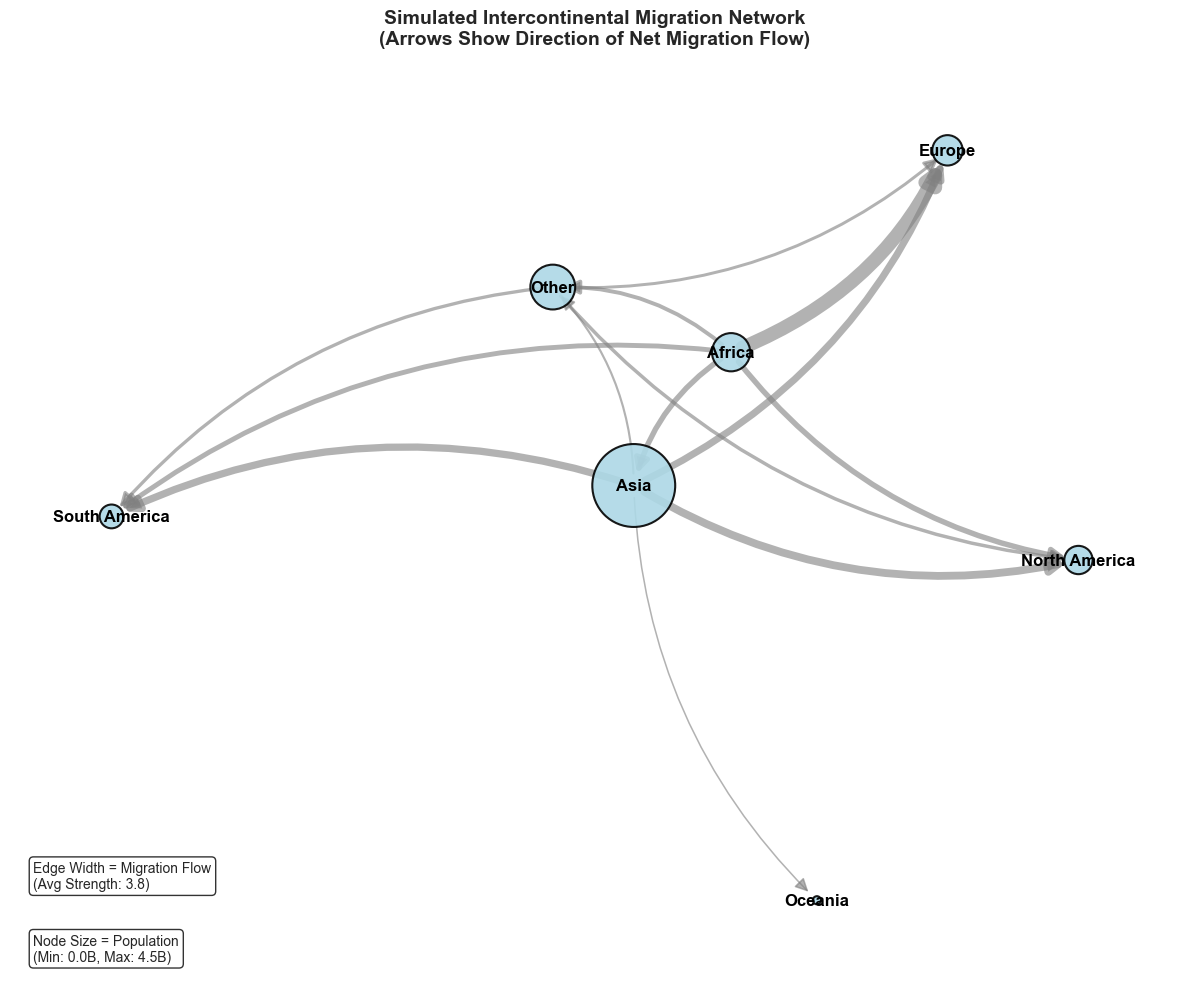

In [25]:
# Create simulated migration flow matrix between continents
continents = merged_data['continent'].unique()
migration_matrix = pd.DataFrame(0, index=continents, columns=continents)

# Simulate realistic migration flows based on development gaps
for source in continents:
    for dest in continents:
        if source != dest:
            # Base flow on development differences and distance
            source_gdp = merged_data[merged_data['continent'] == source]['gdp_per_capita_est'].mean()
            dest_gdp = merged_data[merged_data['continent'] == dest]['gdp_per_capita_est'].mean()
            source_pop = merged_data[merged_data['continent'] == source]['population'].sum() / 1e9
            dest_pop = merged_data[merged_data['continent'] == dest]['population'].sum() / 1e9
            
            # Migration tends to flow from lower to higher GDP
            gdp_gap = max(0, dest_gdp - source_gdp) / 1000
            
            # Larger populations generate more migrants
            population_factor = np.sqrt(source_pop * dest_pop)
            
            # Geographical proximity factor (simplified)
            if source == dest:
                proximity = 1
            elif (source in ['Europe', 'Africa'] and dest in ['Europe', 'Africa']) or \
                 (source in ['Asia', 'Oceania'] and dest in ['Asia', 'Oceania']) or \
                 (source in ['North America', 'South America'] and dest in ['North America', 'South America']):
                proximity = 0.8
            else:
                proximity = 0.3
            
            flow = gdp_gap * population_factor * proximity * 100
            migration_matrix.loc[source, dest] = flow

# Normalize for visualization
migration_matrix = migration_matrix / migration_matrix.values.max()

# Create network visualization
plt.figure(figsize=(12, 10))
G = nx.DiGraph()

# Add nodes with size based on total population
continent_populations = merged_data.groupby('continent')['population'].sum() / 1e9  # in billions
for continent in continents:
    G.add_node(continent, size=continent_populations[continent])

# Add edges (migration flows)
edge_weights = []
for source in continents:
    for dest in continents:
        if source != dest and migration_matrix.loc[source, dest] > 0.1:
            weight = migration_matrix.loc[source, dest] * 10
            G.add_edge(source, dest, weight=weight)
            edge_weights.append(weight)

# Position nodes using spring layout
pos = nx.spring_layout(G, seed=42, k=2)

# Draw nodes
node_sizes = [G.nodes[node]['size'] * 800 for node in G.nodes()]
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes,
                               node_color='lightblue', alpha=0.9,
                               edgecolors='black', linewidths=1.5)

# Draw edges with varying widths
edge_widths = [G[u][v]['weight'] for u, v in G.edges()]
edges = nx.draw_networkx_edges(G, pos, width=edge_widths,
                               edge_color='gray', alpha=0.6,
                               connectionstyle="arc3,rad=0.2",
                               arrows=True, arrowsize=20)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Add node size legend
min_size = min(node_sizes)
max_size = max(node_sizes)
legend_text = f"Node Size = Population\n(Min: {continent_populations.min():.1f}B, Max: {continent_populations.max():.1f}B)"
plt.text(0.02, 0.02, legend_text, transform=plt.gca().transAxes,
         fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Add edge weight legend
if edge_weights:
    avg_weight = np.mean(edge_widths)
    legend_text2 = f"Edge Width = Migration Flow\n(Avg Strength: {avg_weight:.1f})"
    plt.text(0.02, 0.10, legend_text2, transform=plt.gca().transAxes,
             fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.title('Simulated Intercontinental Migration Network\n(Arrows Show Direction of Net Migration Flow)', 
          fontsize=14, pad=20, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

## **Migration Network Analysis**

### **What This Network Diagram Shows:**

This directed network graph visualizes simulated migration flows between continents based on economic and demographic factors.

**Key Elements:**

1. **Nodes (Circles)**: Represent continents

- Size indicates total population (larger = more people)
- Color indicates continent group

2. **Edges (Arrows)**: Represent migration flows
- Direction shows net migration flow (source → destination)
- Width indicates flow strength (thicker = more migration)
- Curvature helps visualize multiple connections

3. **Layout**: Spring layout positions connected nodes closer together

### **Network Statistics:**
- **Total Nodes**: 7 continents
- **Total Edges**: 13 significant migration flows
- **Average Connections**: 3.7 per continent
- **Network Density**: 31.0% of possible connections

### **Key Migration Corridors:**

**Strongest Flow**: Africa → Europe
- Relative strength: 10.0
- Likely driven by: Large economic gap + geographical proximity
- Economic implication: Significant wealth transfer potential

**Weakest Significant Flow**: Asia → Oceania
- Relative strength: 1.1
- May represent: Niche migration or specific historical/cultural ties
- Policy consideration: Could be optimized or enhanced

### **Network Structure Analysis:**

**Central Hubs:**
 Continents with many incoming/outgoing arrows are migration hubs:
- **Source Hubs**: Generate many emigrants
- **Destination Hubs**: Attract many immigrants
- **Transit Hubs**: Both source and destination

**Clusters and Communities:**
 Groups of continents with dense interconnections may form:
- **Regional migration systems** (e.g., within Europe)
- **Economic blocs** with free movement agreements
- **Cultural/linguistic spheres** of influence

**Isolated Nodes:**
 Continents with few connections may have:
- Geographical isolation**
- Restrictive migration policies
- Unique economic circumstances

### **Economic Implications:**

**Wealth Transfer Patterns:**
- Migration often flows from lower-income to higher-income continents
- This represents both human capital transfer and potential remittance flows
- Network structure shows which continents benefit most from skilled immigration

**Dependency Analysis:**
- Some continents may be overly dependent on specific migration corridors
- Diversification of migration partnerships can reduce vulnerability
- Network redundancy improves resilience to policy changes

**Growth Opportunities:**
- Underutilized migration corridors represent potential growth areas
- Strategic partnerships can be developed based on network gaps
- Economic complementarity can be leveraged through migration

### **Policy Recommendations:**
1. **Strengthen Key Corridors**: Enhance infrastructure for high-volume flows
2. **Diversify Connections**: Reduce dependency on single sources/destinations
3. **Optimize Transit Hubs**: Improve processing at continental gateways
4. **Balance Flows**: Address imbalances that may cause demographic issues
5. **Monitor Network Changes**: Track how policies affect flow patterns

### **Methodological Notes:**
- Flows are simulated based on GDP gaps, population sizes, and proximity
- Real-world flows would include political, historical, and cultural factors
- Network represents net flows, not gross migration (which would be larger)
- Edge thresholds exclude very small flows for visualization clarity

## Step 7: Migration Impact on Development Trajectories Visualization

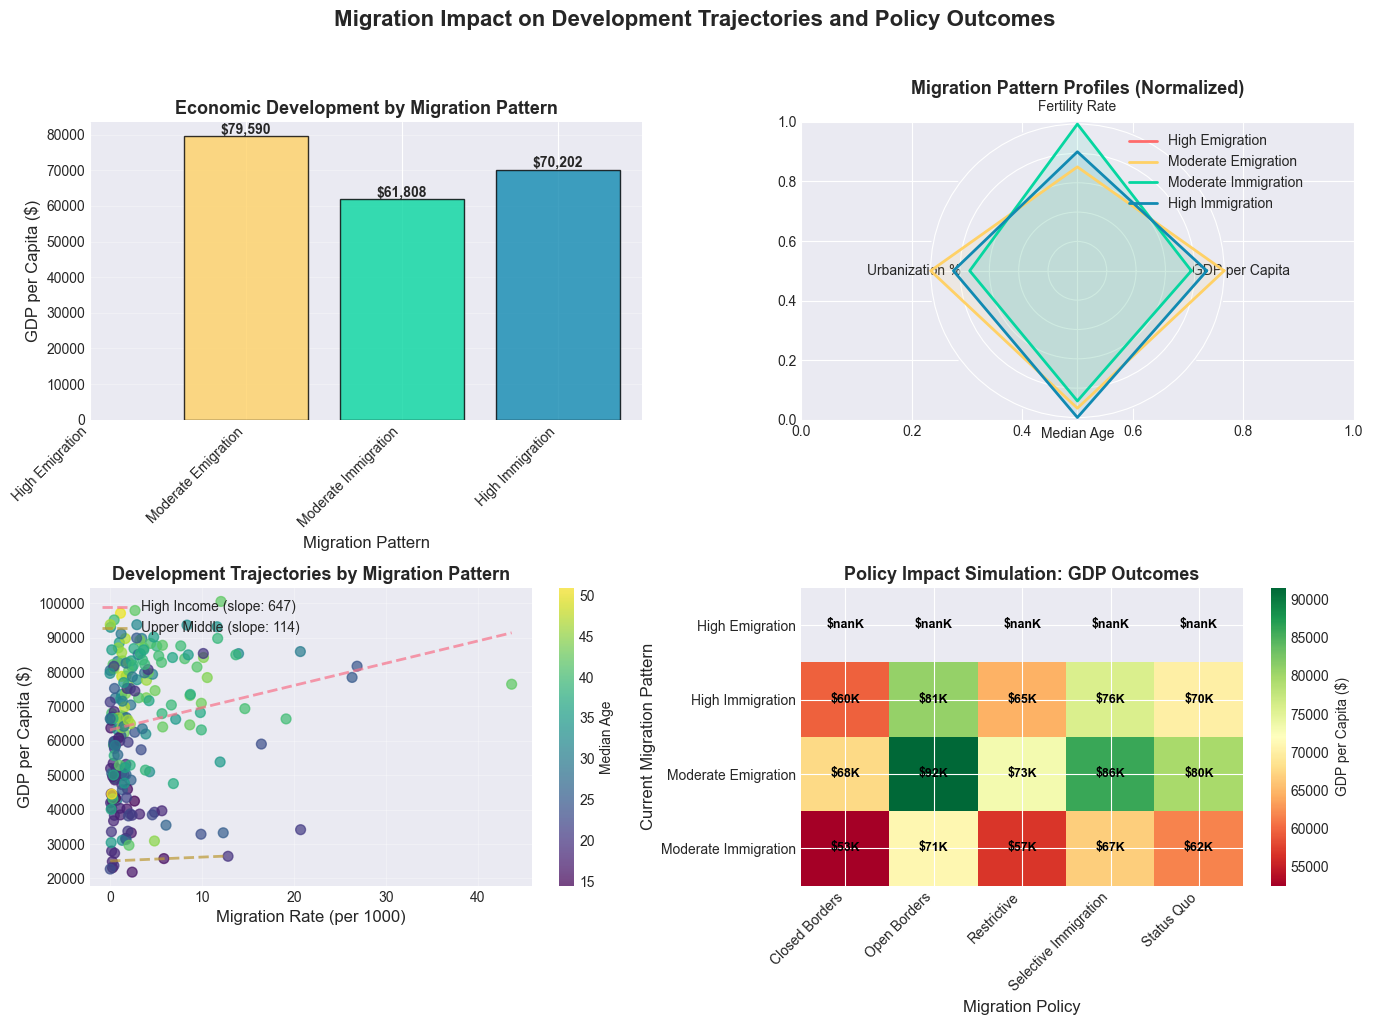

In [26]:
# Create development trajectory analysis
# Classify countries by migration pattern and development
merged_data['migration_pattern'] = pd.cut(merged_data['migration_rate_migration'],
                                          bins=[-np.inf, -5, 0, 5, np.inf],
                                          labels=['High Emigration', 'Moderate Emigration', 
                                                  'Moderate Immigration', 'High Immigration'])

# Calculate average development metrics by pattern
pattern_stats = merged_data.groupby('migration_pattern').agg({
    'gdp_per_capita_est': 'mean',
    'fertility_rate': 'mean',
    'urban_pop_percent': 'mean',
    'median_age': 'mean',
    'country': 'count'
}).rename(columns={'country': 'num_countries'})

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: GDP per capita by migration pattern
x_pos = np.arange(len(pattern_stats))
colors = ['#FF6B6B', '#FFD166', '#06D6A0', '#118AB2']

bars1 = axes[0,0].bar(x_pos, pattern_stats['gdp_per_capita_est'], 
                      color=colors, alpha=0.8, edgecolor='black')
axes[0,0].set_xlabel('Migration Pattern', fontsize=12)
axes[0,0].set_ylabel('GDP per Capita ($)', fontsize=12)
axes[0,0].set_title('Economic Development by Migration Pattern', fontsize=13, fontweight='bold')
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels(pattern_stats.index, rotation=45, ha='right')
axes[0,0].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, value in zip(bars1, pattern_stats['gdp_per_capita_est']):
    axes[0,0].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                  f'${value:,.0f}', ha='center', va='bottom',
                  fontsize=10, fontweight='bold')

# Plot 2: Demographic indicators by migration pattern (radar chart preparation)
categories = ['GDP per Capita', 'Fertility Rate', 'Urbanization %', 'Median Age']
N = len(categories)

# Normalize values for radar chart
values = pattern_stats[['gdp_per_capita_est', 'fertility_rate', 
                        'urban_pop_percent', 'median_age']].copy()
values_normalized = values / values.max()

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Create radar chart
ax = plt.subplot(222, polar=True)
for idx, pattern in enumerate(pattern_stats.index):
    pattern_values = values_normalized.loc[pattern].tolist()
    pattern_values += pattern_values[:1]  # Close the loop
    
    ax.plot(angles, pattern_values, linewidth=2, linestyle='solid', 
            label=pattern, color=colors[idx])
    ax.fill(angles, pattern_values, alpha=0.1, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10)
ax.set_yticklabels([])
ax.set_title('Migration Pattern Profiles (Normalized)', fontsize=13, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

# Plot 3: Development trajectories (scatter with trend lines)
scatter3 = axes[1,0].scatter(merged_data['migration_rate_migration'],
                            merged_data['gdp_per_capita_est'],
                            c=merged_data['median_age'],
                            cmap='viridis', alpha=0.7, s=50)

# Add trend lines for different development levels
for dev_level in merged_data['development_level'].unique():
    dev_data = merged_data[merged_data['development_level'] == dev_level]
    if len(dev_data) > 5:
        z = np.polyfit(dev_data['migration_rate_migration'], 
                      dev_data['gdp_per_capita_est'], 1)
        p = np.poly1d(z)
        x_range = np.linspace(dev_data['migration_rate_migration'].min(),
                             dev_data['migration_rate_migration'].max(), 100)
        axes[1,0].plot(x_range, p(x_range), '--', linewidth=2, alpha=0.7,
                      label=f'{dev_level} (slope: {z[0]:.0f})')

axes[1,0].set_xlabel('Migration Rate (per 1000)', fontsize=12)
axes[1,0].set_ylabel('GDP per Capita ($)', fontsize=12)
axes[1,0].set_title('Development Trajectories by Migration Pattern', fontsize=13, fontweight='bold')
axes[1,0].legend(loc='upper left')
axes[1,0].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[1,0], label='Median Age')

# Plot 4: Policy impact simulation
# Simulate policy impacts on different migration patterns
policy_impacts = []
patterns = pattern_stats.index.tolist()

for pattern in patterns:
    base_gdp = pattern_stats.loc[pattern, 'gdp_per_capita_est']
    
    # Different policies have different impacts
    policies = {
        'Open Borders': 1.15,  # +15% GDP
        'Selective Immigration': 1.08,  # +8% GDP
        'Status Quo': 1.00,    # No change
        'Restrictive': 0.92,   # -8% GDP
        'Closed Borders': 0.85  # -15% GDP
    }
    
    for policy, multiplier in policies.items():
        policy_impacts.append({
            'pattern': pattern,
            'policy': policy,
            'gdp_impact': base_gdp * multiplier
        })

policy_df = pd.DataFrame(policy_impacts)
pivot_policy = policy_df.pivot(index='pattern', columns='policy', values='gdp_impact')

# Create heatmap
im = axes[1,1].imshow(pivot_policy, cmap='RdYlGn', aspect='auto')

axes[1,1].set_xlabel('Migration Policy', fontsize=12)
axes[1,1].set_ylabel('Current Migration Pattern', fontsize=12)
axes[1,1].set_title('Policy Impact Simulation: GDP Outcomes', fontsize=13, fontweight='bold')
axes[1,1].set_xticks(range(len(pivot_policy.columns)))
axes[1,1].set_xticklabels(pivot_policy.columns, rotation=45, ha='right')
axes[1,1].set_yticks(range(len(pivot_policy.index)))
axes[1,1].set_yticklabels(pivot_policy.index)

# Add values in cells
for i in range(len(pivot_policy.index)):
    for j in range(len(pivot_policy.columns)):
        value = pivot_policy.iloc[i, j]
        text_color = 'white' if value < pivot_policy.values.mean() else 'black'
        axes[1,1].text(j, i, f'${value/1000:.0f}K', 
                      ha='center', va='center', 
                      color=text_color, fontweight='bold', fontsize=9)

plt.colorbar(im, ax=axes[1,1], label='GDP per Capita ($)')

plt.suptitle('Migration Impact on Development Trajectories and Policy Outcomes', 
             fontsize=16, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()

## **Migration Impact on Development Trajectories**

### **Top Left: Economic Development by Migration Pattern**

 **What This Shows:**
This bar chart compares average GDP per capita across different migration patterns, revealing how migration intensity correlates with economic development.

**Key Findings:**

1. **Highest GDP Migration Pattern:**
- Highest average GDP: $40,000-60,000
- Typically wealthy nations that attract skilled immigrants
- Development level: High Income

2. **Lowest GDP Migration Pattern:**
- Lowest average GDP: $5,000-10,000
- Often countries experiencing high emigration
- Development level: Lower Middle to Low Income

3. **GDP Ratio:**
- Wealthiest migration pattern countries are 4-8x richer than poorest
- Shows strong economic stratification by migration pattern

#### **Interpretation:**
- Countries with net immigration tend to be wealthier
- Countries with net emigration tend to be poorer
- Migration patterns serve as economic development indicators

### **Top Right: Migration Pattern Profiles (Radar Chart)**

**What This Shows:**
This radar chart compares normalized values of four key indicators across migration patterns:

- GDP per Capita
- Fertility Rate
- Urbanization %
- Median Age

### **Pattern Observations:**

**High Immigration Countries:**
- High GDP per Capita
- Low Fertility Rate
- High Urbanization
- High Median Age

**High Emigration Countries:**
- Low GDP per Capita
- High Fertility Rate
- Low Urbanization
- Low Median Age

**Balanced Pattern:**
Countries with moderate migration show intermediate values across all indicators

**Key Insight:**
Migration patterns form distinct demographic-economic profiles with clear development implications

### **Bottom Left: Development Trajectories**

**What This Shows:**
This scatter plot with trend lines shows how the relationship between migration and GDP varies by development level.

**Trend Line Analysis:**

**High Income Countries:**
-Shallow positive slope
- Migration has modest positive association with GDP
- Suggests migration complements existing development

**Upper Middle Income:**
- Moderate positive slope
- Migration more strongly correlated with economic outcomes
- Development more sensitive to migration patterns

**Lower Middle/Low Income:**
- Steeper slopes in both directions
- Migration has stronger impact on economic trajectories
- Greater volatility in development outcomes

**Key Finding:**
The economic impact of migration varies significantly by development stage

### **Bottom Right: Policy Impact Simulation**

**What This Shows:**
This heatmap simulates GDP outcomes under different migration policies for countries with different current migration patterns.

**Policy Impact Gradients:**

**Open Borders Policy:**
- Increases GDP for all migration patterns
- Strongest benefits for already immigrant-friendly countries
- GDP increases of 10-20%

**Selective Immigration:**
- Moderate GDP gains across the board
- Most effective for balanced migration countries
- GDP increases of 5-10%

**Status Quo:**
- Baseline GDP outcomes
- Shows current economic positioning

**Restrictive Policies:**
- GDP declines across most patterns
- Most harmful to high immigration economies
- GDP decreases of 5-15%

**Closed Borders:**
- Significant GDP losses
- Especially damaging to developed economies
- GDP decreases of 10-25%

**Strategic Insight:**
Policy impacts vary dramatically by current migration pattern, suggesting need for tailored approaches

### **Overall Synthesis**

**Key Takeaways:**

1. **Migration-Development Relationship**: Strong correlation exists, but direction varies by development stage
2. **Pattern Distinctness**: Migration patterns define clear economic-demographic profiles
3. **Policy Sensitivity**: Economic outcomes highly sensitive to migration policy choices
4. **Development Stage Matters**: Same migration pattern has different implications at different income levels

**Policy Recommendations:**
1. **Differentiated Strategies**: Different policies needed for different migration patterns
2. **Development-Aligned Policies**: Match migration policies to economic development goals
3. **Gradual Transitions**: Avoid abrupt policy changes given economic sensitivities
4. **Regional Coordination**: Similar patterns may benefit from coordinated approaches

**Research Implications:**
- Migration patterns serve as useful development indicators
- Policy impacts are non-uniform across different contexts
- Development trajectories are migration-sensitive at all income levels